In [1]:
import re
import time
import copy
import jieba
import fiona
import itertools
import collections
import numpy  as np 
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

from shapely import geos
from wordcloud import WordCloud
from collections import Counter
from shapely.geometry import Point
from fiona.crs import from_epsg,from_string

In [2]:
plt.rcParams['font.sans-serif']    = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
colors = ['#121557', '#191E80', '#234797', '#2B6FAE', '#3495C6', '#8DD0D0', '#CCE8C8']

In [3]:
data_file   = "./data/python_backend.csv"
map_file    = "./geojson/shenzhen.json"
street_file = "./geojson/shenzhen_street.json"
font_file   = "./font/simhei.ttf"

In [4]:
df = pd.read_csv(data_file)

这里进行一些简单的数据处理，删除不需要的列，过滤掉搜索系统出来的其它职位信息。

In [5]:
df = df.drop('Unnamed: 0', axis = 1)

dirty_key_words = ['前端', 'Java', 'java', 'PHP', 'php', 'Node', 'node', 'C', 'c', '.NET', '.Net', 
                   'IOS', 'iOS', 'Android', 'android', 'Unity3D', 'Unity3d', 'unity3d', 
                   'H5', 'h5', 'UI', 'ui', '移动端', '实习', '美术', '美工', '特效师']
for i in dirty_key_words:
    df = df.drop(df[df['positionName'].str.contains(i)].index)

In [6]:
df.head(3)

,activeTime,companyFullName,companySize,createTime,district,education,financeStage,industryField,jobDetail,pageUrl,positionLat,positionLng,positionName,salary,skillLables,stationname,workAddr,workYear
0,早10点最活跃,北京市商汤科技开发有限公司,2000人以上,2019-10-23 00:23:06,南山区,本科,C轮,人工智能,职位描述： 工作职责:1.参与产品的需求分析以及产品程序架构和...,https://www.lagou.com/jobs/6159169.html,22.528499,113.923552,高级Python开发工程师,18k-35k,['Python'],南山,深圳-南山区-前海-深圳湾生态科技园11栋,不限
1,下午6点最活跃,深圳迪巨智能科技有限公司,15-50人,2019-10-26 15:29:11,南山区,本科,天使轮,"硬件,人工智能",职位描述： 岗位职责：1.负责AI智能平台核心组件的设计、开发...,https://www.lagou.com/jobs/6540914.html,22.593802,114.004825,python开发工程师,15k-30k,"['Python', 'Linux/Unix']",塘朗,深圳-南山区-学苑大道南山智园A7栋1302,1-3年
2,下午6点最活跃,汇才易科技（深圳）有限公司,500-2000人,2019-10-25 14:41:21,南山区,本科,未融资,"电商,软件开发",职位描述： 岗位职责：1、负责AI分析平台核心组件的设计、开发...,https://www.lagou.com/jobs/6538328.html,22.537493,113.956082,python研发工程师,18k-30k,"['Python', '后端', '分布式']",高新园,深圳-南山区-大冲-深圳市南山区科技园科技南12路迈瑞大厦D座4A,1-3年


* 简单统计

最终的数据集一共爬取了 `354` 个职位。

In [7]:
len(df)

353

这里获取得到发布的职位关键字的`Top 10`。

发布的部分职位名称中包含了一些不需要的字符串，如：`Python后台工程师(科技园), 11217M-资深python开发（平安云）, 测试工程师-Airpay`，这里进行了处理。即取出括号内的文字（包含括号）、删除`-`前后包含英文或数字或英文数字的字符串（包含`-`）。

In [8]:
position_count = collections.Counter([re.sub('[{|\(|（|【](.*?)[】|）|\)|}]|[a-zA-Z|\d|a-zA-Z\d]+[-]|[-][a-zA-Z|\d|a-zA-Z\d]+| ', '', i).lower() for i in df['positionName'].to_list()])
position_count = sorted(position_count.items(), key = lambda position_count:position_count[1], reverse = True)

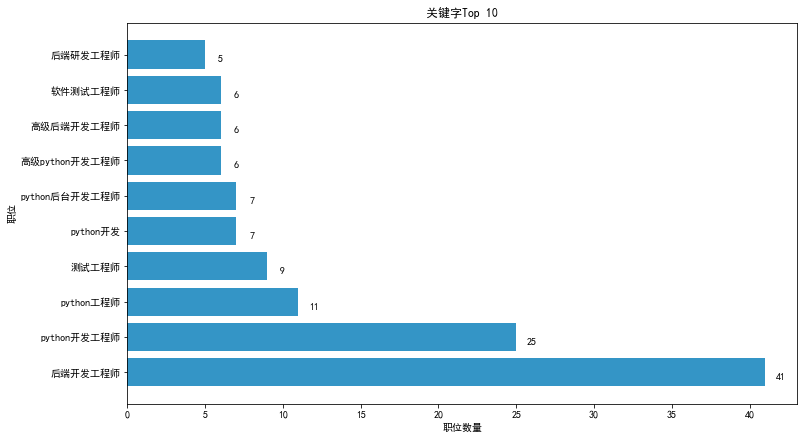

In [9]:
fig     = plt.figure(figsize = (12, 7))
ax      = plt.subplot(111)
y_index = np.arange(10)
y_width = 0.4

cm = plt.cm.get_cmap('RdYlBu')

ax.barh(y_index, [i[1] for i in position_count[:10]], color = colors[-3])

ax.set_xlabel('职位数量')
ax.set_ylabel('职位')
ax.set_title('关键字Top 10')
for xx, yy in zip([i[1] for i in position_count[:10]], y_index):
    ax.text(xx + 1.0, 
            yy - 0.25, 
            '%.0f' % xx, 
            ha = 'center', 
            va = 'bottom')

ax.set_yticks(y_index)
ax.set_yticklabels([i[0] for i in position_count[:10]])

plt.show()

* `HR`活跃时间分布

In [10]:
def cover_time(desc_str):
    t = re.findall(r"\d+\.?\d*", desc_str)[0]
    t = int(t)
    if '下午' in desc_str or '晚上' in desc_str:
        t = t + 12
    return t

In [11]:
for row in df.iterrows():
    if pd.isnull(row[1]['activeTime']):
        continue
    elif  '--点' in row[1]['activeTime']:
        df.loc[row[0], 'activeTime'] = np.nan
    else:
        df.loc[row[0], 'activeTime'] = cover_time(row[1]['activeTime'].split('最')[0])

In [12]:
active_time_count = collections.Counter(df['activeTime'].to_list())
for i in range(1, 24, 1):
    if i not in active_time_count:
        active_time_count.update({
            i: 0
        })
active_time_count = sorted(active_time_count.items(), key = lambda active_time_count:active_time_count[0])

posx and posy should be finite values
posx and posy should be finite values


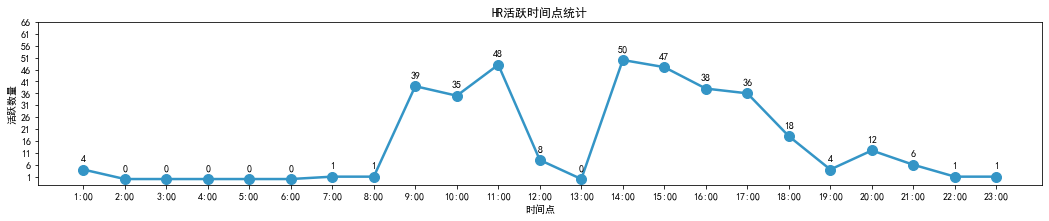

In [13]:
fig = plt.figure(figsize = (18, 3))
ax  = plt.subplot(111)

ax.plot([i[0] for i in active_time_count if not pd.isnull(i[0])],
         [i[1] for i in active_time_count if not pd.isnull(i[0])],
         color     = colors[-3],
         marker    = 'o',
         ms        = 10,
         linewidth = 2.5
        )

ax.set_xlabel('时间点')
ax.set_ylabel('活跃数量')
ax.set_title('HR活跃时间点统计')
for xx, yy in zip([i[0] for i in active_time_count], [i[1] for i in active_time_count]):
    ax.text(xx, 
            yy + 3, 
            '%.0f' % yy, 
            ha = 'center', 
            va = 'bottom')

ax.set_yticks(np.arange(1, 70, 5))
ax.set_xticks(np.arange(1, 24, 1))
ax.set_xticklabels([str(i) + ":00" for i in np.arange(1, 24, 1)])
plt.show()

通过分析`HR`的活跃时间，可以知道在大概早上`09:00 ~ 11:00` 和下午`14:00 ~ 18:00`这两个时间段进行简历投递会比较好。

* 薪资关系

In [14]:
def salary_low_high(salary_df, group_by_col):
    labels           = []
    salary_low_mean  = []
    salary_high_mean = []

    for sub_df in salary_df.groupby(group_by_col):
        salary_range = []
        labels.append(sub_df[0])
        for i in sub_df[1]['salary'].to_list():
            salary_range.append([int(j) for j in i.replace('k', '').split('-')])
        low_sum  = 0
        high_sum = 0
        for i in salary_range:
            low_sum  += i[0]
            high_sum += i[1]
        low_mean, high_mean = low_sum / len(salary_range) * 1000, high_sum / len(salary_range) * 1000
        salary_low_mean.append(low_mean)
        salary_high_mean.append(high_mean)
    return labels, salary_low_mean, salary_high_mean

In [15]:
def salary_low_high_plt(labels, salary_low_mean, salary_high_mean, y_label):
    ax      = plt.subplot(111)
    x_index = np.arange(len(labels))
    x_width = 0.4

    ax.bar(x_index,           salary_low_mean,  x_width, label = "平均最低月薪", color = colors[-1])
    ax.bar(x_index + x_width, salary_high_mean, x_width, label = "平均最高月薪", color = colors[-4])

    ax.set_xlabel('平均月薪')
    ax.set_ylabel(y_label)
    ax.set_title('平均薪资')
    for xx1, yy1, xx2, yy2 in zip(x_index, salary_low_mean, x_index + x_width, salary_high_mean):
        ax.text(xx1, yy1, '%.1f' % yy1, ha = 'center', va = 'bottom')
        ax.text(xx2, yy2, '%.1f' % yy2, ha = 'center', va = 'bottom')
    ax.legend()

    ax.set_xticks(x_index)
    ax.set_xticklabels(labels)

    plt.show()

* 工作年限

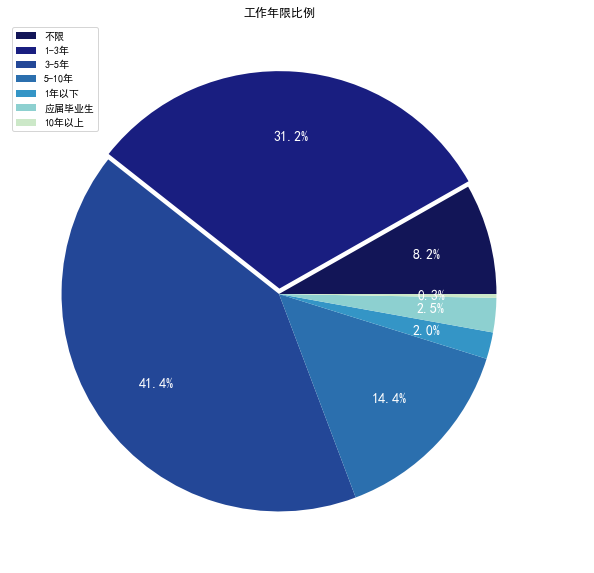

In [16]:
fig                 = plt.figure(figsize = (10, 10))
salary_work_year_df = df[['salary', 'workYear']]
work_year_counter   = collections.Counter(salary_work_year_df['workYear'].to_list())

plt.pie(work_year_counter.values(),
        labels      = work_year_counter.keys(),
        colors      = colors,
        autopct     ='%1.1f%%',
        pctdistance = 0.7,
        startangle  = 0,
        explode    = (0, 0.025, 0, 0, 0, 0, 0),
        textprops   = {'fontsize': 14, 'color': 'w'}
       )

plt.title('工作年限比例')
plt.legend()
plt.show()

大部分企业需要的是工作经验为`1 ~ 3年`或者`3 ~ 5年`的求职者，其中需要工作经验`3 ~ 5`年的需求最大。

In [17]:
labels, salary_low_mean, salary_high_mean = salary_low_high(salary_work_year_df, 'workYear')

In [18]:
print("平均最低薪酬：%0.2f" % np.mean(salary_low_mean))
print("平均最高薪酬：%0.2f" % np.mean(salary_high_mean))

平均最低薪酬：15978.65
平均最高薪酬：28998.44


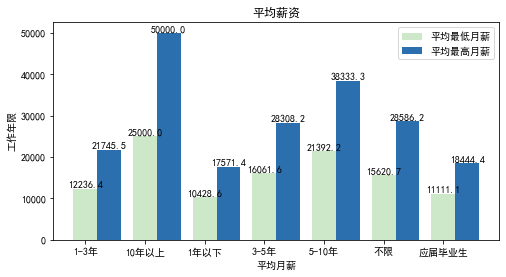

In [19]:
fig     = plt.figure(figsize = (8, 4))
salary_low_high_plt(labels, salary_low_mean, salary_high_mean, '工作年限')

可以看出，薪酬随着工作经验的增加也是水涨船高。

    1) `1 ~ 3年`经验的求职者平均最低月薪为`12k`以上，最低平均最高月薪为`20k`以上；

    2) `3 ~ 5年`经验的求职者平均最低月薪为`16k`以上，最低平均最高月薪为`28k`以上。

* 学历要求

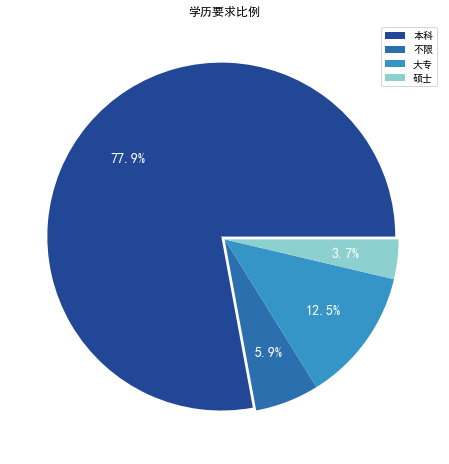

In [20]:
fig                 = plt.figure(figsize = (8, 8))
salary_education_df = df[['salary', 'education']]
education_counter   = collections.Counter(salary_education_df['education'].to_list())

plt.pie(education_counter.values(),
        labels      = education_counter.keys(),
        colors      = colors[2:6],
        autopct     ='%1.1f%%',
        pctdistance = 0.7,
        startangle  = 0,
        explode    = (0.025, 0, 0, 0),
        textprops   = {'fontsize': 14, 'color': 'w'}
       )

plt.title('学历要求比例')
plt.legend()
plt.show()

In [21]:
labels, salary_low_mean, salary_high_mean = salary_low_high(salary_education_df, 'education')

In [22]:
print("平均最低薪酬：%0.2f" % np.mean(salary_low_mean))
print("平均最高薪酬：%0.2f" % np.mean(salary_high_mean))

平均最低薪酬：16114.64
平均最高薪酬：29445.84


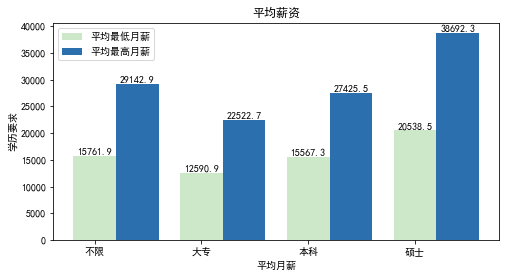

In [23]:
fig     = plt.figure(figsize = (8, 4))
salary_low_high_plt(labels, salary_low_mean, salary_high_mean, '学历要求')

* 公司规模

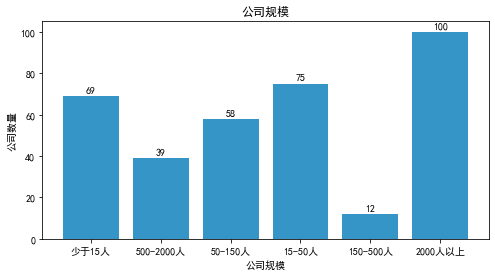

In [24]:
labels      = list(set(df['companySize'].to_list()))
size_count  = collections.Counter(df['companySize'].to_list())

fig         = plt.figure(figsize = (8, 4))
ax          = plt.subplot(111)
x_index     = np.arange(len(labels))

ax.bar(x_index, size_count.values(), color = colors[-3])

ax.set_xlabel('公司规模')
ax.set_ylabel('公司数量')
ax.set_title('公司规模')
for xx, yy in zip(x_index, size_count.values()):
    ax.text(xx, 
            yy + 1, 
            '%d' % yy, 
            ha = 'center', 
            va = 'bottom')

ax.set_xticks(x_index)
ax.set_xticklabels(labels)

plt.show()

* 融资情况

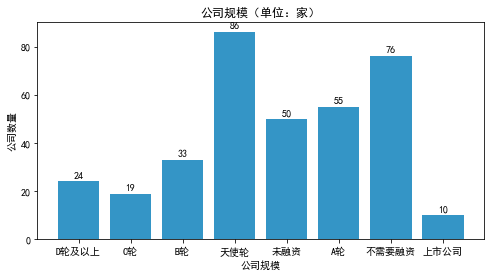

In [25]:
labels      = list(set(df['financeStage'].to_list()))
size_count  = collections.Counter(df['financeStage'].to_list())

fig         = plt.figure(figsize = (8, 4))
ax          = plt.subplot(111)
x_index     = np.arange(len(labels))

ax.bar(x_index, size_count.values(), color = colors[-3])

ax.set_xlabel('公司规模')
ax.set_ylabel('公司数量')
ax.set_title('公司规模（单位：家）')
for xx, yy in zip(x_index, size_count.values()):
    ax.text(xx, 
            yy + 1, 
            '%d' % yy, 
            ha = 'center', 
            va = 'bottom')

ax.set_xticks(x_index)
ax.set_xticklabels(labels)

plt.show()

In [26]:
finance_stage_company_size_df = df[['financeStage', 'companySize']]
finance_stage_company_size_df['count'] = 1

c:\users\jason\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [27]:
finance_stage_company_size_pivot_table = pd.pivot_table(finance_stage_company_size_df,
                                                        index      = ['financeStage', 'companySize'],
                                                        aggfunc    = 'sum',
                                                        fill_value = 0,
                                                        dropna     = False
                                                       )

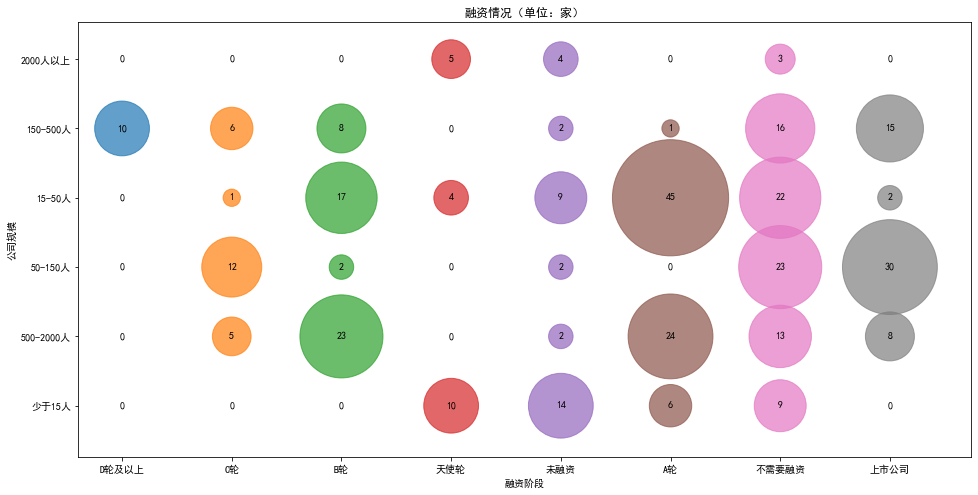

In [28]:
fig      = plt.figure(figsize = (16, 8))
ax       = plt.subplot(111)
x_labels = list(set(df['financeStage'].to_list()))
y_labels = list(set(df['companySize'].to_list()))

for index, i in enumerate(x_labels):
    temp = finance_stage_company_size_pivot_table.query('financeStage == ["{}"]'.format(i))
    temp = dict(temp['count'])
    temp = {i[1]: temp[i] for i in temp}
    ax.scatter(np.array([index] * 6), 
               np.arange(6), 
               s     = np.array(list(temp.values())) * 300, 
               cmap  = plt.cm.get_cmap('Blues'), 
               alpha = 0.7)
    for i in range(0, 6, 1):
        ax.text(index, 
                i - 0.05, 
                '%d' % temp[list(temp.keys())[i]], 
                ha = 'center', 
                va = 'bottom')

ax.set_xticks(np.arange(8))
ax.set_xticklabels(x_labels)
ax.set_yticks(np.arange(6))
ax.set_yticklabels(y_labels)

ax.set_xlabel('融资阶段')
ax.set_ylabel('公司规模')
ax.set_title('融资情况（单位：家）')

plt.show()

这张图展现了不同融资阶段的公司规模。

* 地区分布

In [29]:
district_data = Counter(df['district'].tolist())
district_name = list(district_data.keys())
for i in district_name:
    try:
        district_data[i[:2]] = district_data.pop(i)
    except Exception as e:
        continue

In [30]:
map_df           = gpd.read_file(map_file)
map_df['coords'] = map_df['geometry'].apply(
                lambda x: x.representative_point().coords[:])
map_df['coords'] = [coords[0] for coords in map_df['coords']]
map_df['companyCount'] = 0
for row in map_df.iterrows():
    map_df.loc[row[0], 'name']         = row[1]['name'][:2]
    map_df.loc[row[0], 'companyCount'] = district_data.get(row[1]['name'][:2], 0)

In [31]:
position_df = df[['positionLat', 'positionLng', 'stationname', 'workAddr']]
position_df.dropna(axis = 0, how = 'any', inplace = True)
position_df['geometry'] = gpd.GeoSeries(
                list(zip(position_df['positionLng'], position_df['positionLat']))
            ).apply(Point)

position_df     = gpd.GeoDataFrame(position_df)
position_df.crs = {'init':'epsg:4326'}

c:\users\jason\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\jason\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:4: FutureWarning:     You are passing non-geometry data to the GeoSeries constructor. Currently,
    it falls back to returning a pandas Series. But in the future, we will start
    to raise a TypeError instead.
  after removing the cwd from sys.path.
c:\users\jason\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas

c:\users\jason\appdata\local\programs\python\python37-32\lib\site-packages\pysal\explore\segregation\network\network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
c:\users\jason\appdata\local\programs\python\python37-32\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


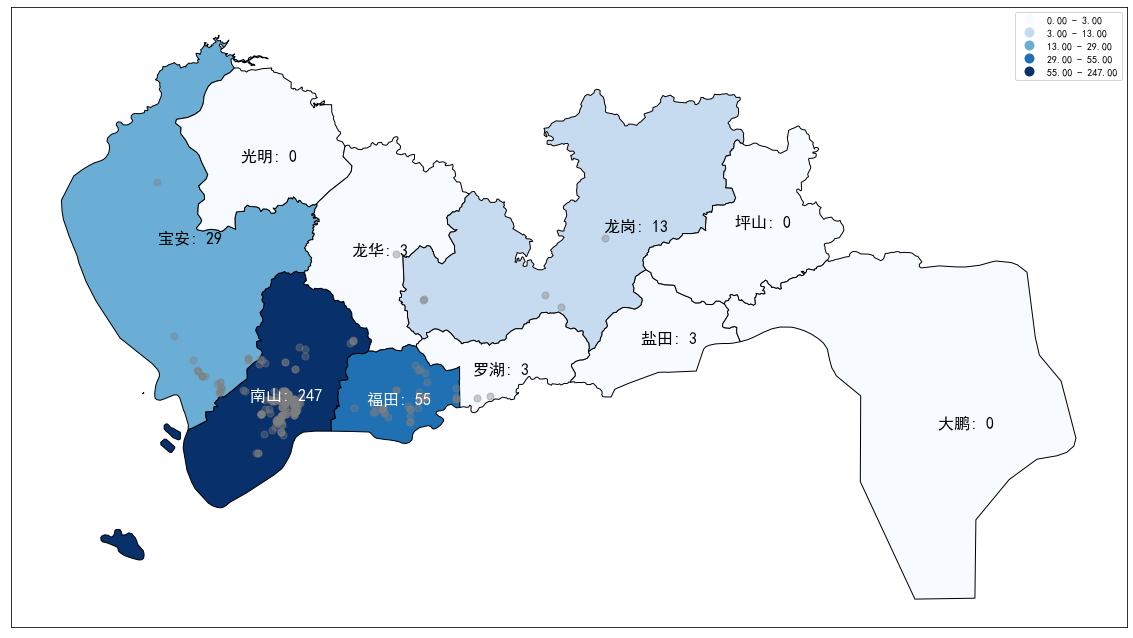

In [32]:
base_map = map_df.plot(
                column    = 'companyCount',
                cmap      = 'Blues',
                scheme    = 'fisher_jenks',
                legend    = True,
                edgecolor = 'black',
                figsize   = (20, 20)
            )

position_df.plot(ax = base_map, color = 'gray', markersize = 50, alpha = 0.4)
for idx, row in map_df.iterrows(): 
    plt.annotate(s  = row['name'] + ": " + str(row['companyCount']),
                 xy = [row['coords'][0], row['coords'][1] - 0.01],
                 horizontalalignment = 'center',
                 fontsize = 16,
                 color    = 'white' if row['companyCount'] > 30 else 'black')

plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

主要的公司位置集中在`南山`，`福田`，`宝安`这三个区。

* 技能标签

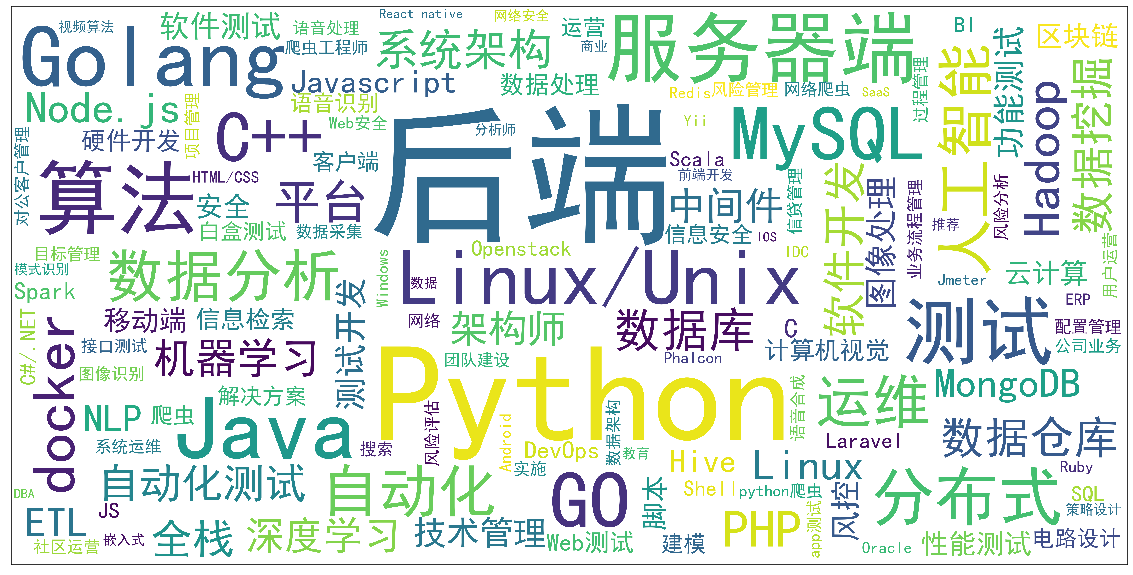

In [33]:
skill_lables_list  = itertools.chain(*[eval(i) for i in df['skillLables'].to_list()])
skill_lables_count = collections.Counter(skill_lables_list)

plt.figure(figsize   = (20, 20))

wordcloud = WordCloud(font_path        = font_file,
                      scale            = 20,
                      background_color = 'white')
wordcloud = wordcloud.fit_words(skill_lables_count)

plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.imshow(wordcloud)
plt.show()

* 关键字 `Top K`

这边对爬取到的职位描述进行了分词，提取其中出现的关键词，并做相关的统计。

In [ ]:
detail_key_words = []
for row in df.iterrows():
    if not pd.isnull(row[1]['jobDetail']):
        job_detail = row[1]['jobDetail'].replace('职位描述：                ', '').replace('岗位职责：', '').lower()
        detail_key_words.extend(list(jieba.cut(job_detail)))
    else:
        print("Without job detail. ...")

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\jason\AppData\Local\Temp\jieba.cache


In [ ]:
def is_chinese(uchar):
    if '\u4e00' <= uchar <= '\u9fa5':
        return True
    else:
        return False

对一些特殊字符进行过滤。

In [ ]:
detail_frequency = collections.Counter(detail_key_words)

for special in "、，, ；！：。.“”&·s\xa0\u2028\u3000【】()（）+-'︶︵~－一–／/的和有等及对年1234567":
    del detail_frequency[special]

In [ ]:
def show_frequency(k, key_word_count, x_offset = 10, y_offset = - 0.25):
    ax      = plt.subplot(111)
    y_index = np.arange(k)
    y_width = 0.4

    ax.barh(y_index, [i[1] for i in key_word_count[:k]], color = colors[-3])

    ax.set_xlabel('数量')
    ax.set_ylabel('关键字')
    ax.set_title('关键字Top %d'%k)
    for xx, yy in zip([i[1] for i in key_word_count[:k]], y_index):
        ax.text(xx + x_offset, 
                yy + y_offset, 
                '%.0f' % xx, 
                ha = 'center', 
                va = 'bottom')

    ax.set_yticks(y_index)
    ax.set_yticklabels([i[0] for i in key_word_count[:k]])

    plt.show()

下面是对中文关键词的统计并可视化。

In [ ]:
chinese_frequency  = copy.deepcopy(detail_frequency)
chinese_keys       = [i for i in list(chinese_frequency.keys()) if not is_chinese(i[0]) or len(i) == 1]
for key in chinese_keys:
    del chinese_frequency[key]

chinese_frequency  = sorted(chinese_frequency.items(), key = lambda chinese_frequency: chinese_frequency[1], reverse = True)
fig = plt.figure(figsize = (12, 7))
show_frequency(20, chinese_frequency, x_offset = 30)

从上面的`关键词Top20`可以看出，所招聘的职位更加强调的是技能的把握、熟悉程度，以及工作经验、能力等。

下面是对英文关键词的统计并可视化。

In [ ]:
def is_alphabet(uchar):
    if (uchar >= u'\u0041' and uchar<=u'\u005a') or (uchar >= u'\u0061' and uchar<=u'\u007a'):
        return True
    else:
        return False

In [ ]:
alphabet_frequency = copy.deepcopy(detail_frequency)
alphabet_keys      = [i for i in list(alphabet_frequency.keys()) if not is_alphabet(i[0])]
for key in alphabet_keys:
    del alphabet_frequency[key]

alphabet_frequency = sorted(alphabet_frequency.items(), key = lambda alphabet_frequency: alphabet_frequency[1], reverse = True)
fig = plt.figure(figsize = (12, 7))
show_frequency(50, alphabet_frequency, x_offset = 5, y_offset = - 0.25)

这张图大致展示了职位需要大概掌握的技能，职位更加强调数据库、缓存、`Linux`、网络`TCP`、`Web`等的掌握程度。

而就`Python后端`而言，有些职位可能不仅仅要求掌握`Python`这门语言，还会要求掌握`Java`，`Golang`，`C/C++`等多门语言。